<a href="https://colab.research.google.com/github/adikulkarni11/Machine-Learning-Models/blob/main/Multi_Class_Classification_using_Reuters_Newswires.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Aditya Kulkarni

# Classifying newswires: a multi-class classification example

This notebook contains the code samples found in Chapter 3, Section 5 of [Deep Learning with Python](https://www.manning.com/books/deep-learning-with-python?a_aid=keras&a_bid=76564dff). Note that the original text features far more content, in particular further explanations and figures: in this notebook, you will only find source code and related comments.

----

In the previous section we saw how to classify vector inputs into two mutually exclusive classes using a densely-connected neural network. 
But what happens when you have more than two classes? 

In this section, we will build a network to classify Reuters newswires into 46 different mutually-exclusive topics. Since we have many 
classes, this problem is an instance of "multi-class classification", and since each data point should be classified into only one 
category, the problem is more specifically an instance of "single-label, multi-class classification". If each data point could have 
belonged to multiple categories (in our case, topics) then we would be facing a "multi-label, multi-class classification" problem.

## The Reuters dataset


We will be working with the _Reuters dataset_, a set of short newswires and their topics, published by Reuters in 1986. It's a very simple, 
widely used toy dataset for text classification. There are 46 different topics; some topics are more represented than others, but each 
topic has at least 10 examples in the training set.

Like IMDB and MNIST, the Reuters dataset comes packaged as part of Keras. Let's take a look right away:

In [ ]:
import keras
keras.__version__

Using TensorFlow backend.


'2.3.1'

In [ ]:
from keras.datasets import reuters

(train_data, train_labels), (test_data, test_labels) = reuters.load_data(num_words=10000)


Like with the IMDB dataset, the argument `num_words=10000` restricts the data to the 10,000 most frequently occurring words found in the 
data.

We have 8,982 training examples and 2,246 test examples:

In [ ]:
len(train_data)

8982

In [ ]:
len(test_data)

2246

As with the IMDB reviews, each example is a list of integers (word indices):

In [ ]:
train_data[10]

[1,
 245,
 273,
 207,
 156,
 53,
 74,
 160,
 26,
 14,
 46,
 296,
 26,
 39,
 74,
 2979,
 3554,
 14,
 46,
 4689,
 4329,
 86,
 61,
 3499,
 4795,
 14,
 61,
 451,
 4329,
 17,
 12]

Here's how you can decode it back to words, in case you are curious:

In [ ]:
word_index = reuters.get_word_index()
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])
# Note that our indices were offset by 3
# because 0, 1 and 2 are reserved indices for "padding", "start of sequence", and "unknown".
decoded_newswire = ' '.join([reverse_word_index.get(i - 3, '?') for i in train_data[0]])

In [ ]:
decoded_newswire

'? ? ? said as a result of its december acquisition of space co it expects earnings per share in 1987 of 1 15 to 1 30 dlrs per share up from 70 cts in 1986 the company said pretax net should rise to nine to 10 mln dlrs from six mln dlrs in 1986 and rental operation revenues to 19 to 22 mln dlrs from 12 5 mln dlrs it said cash flow per share this year should be 2 50 to three dlrs reuter 3'

The label associated with an example is an integer between 0 and 45: a topic index.

In [ ]:
train_labels[10]

3

In [ ]:
train_data.shape

(8982,)

In [ ]:
texts = []
for data in train_data:
    decoded_newswire = ' '.join([reverse_word_index.get(i - 3, '?') for i in data])
    texts.append(decoded_newswire)

In [ ]:
texts[:2]

['? ? ? said as a result of its december acquisition of space co it expects earnings per share in 1987 of 1 15 to 1 30 dlrs per share up from 70 cts in 1986 the company said pretax net should rise to nine to 10 mln dlrs from six mln dlrs in 1986 and rental operation revenues to 19 to 22 mln dlrs from 12 5 mln dlrs it said cash flow per share this year should be 2 50 to three dlrs reuter 3',
 '? generale de banque sa lt ? br and lt heller overseas corp of chicago have each taken 50 pct stakes in ? company sa ? factors generale de banque said in a statement it gave no financial details of the transaction sa ? ? turnover in 1986 was 17 5 billion belgian francs reuter 3']

## Preparing the data

We can vectorize the data with the exact same code as in our previous example:

In [ ]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import numpy as np

maxlen = 500  # We will cut reviews after 500 words
training_samples = 7000  # We will be training on 7000 samples
validation_samples = 1982  # We will be validating on 1982 samples
max_words = 10000  # We will only consider the top 10,000 words in the dataset

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

data = pad_sequences(sequences, maxlen=maxlen)

print('Shape of data tensor:', data.shape)


from keras.utils.np_utils import to_categorical

one_hot_train_labels = to_categorical(train_labels)
one_hot_test_labels = to_categorical(test_labels)


x_train = data[:training_samples]
y_train = one_hot_train_labels[:training_samples]
x_val = data[training_samples: training_samples + validation_samples]
y_val = one_hot_train_labels[training_samples: training_samples + validation_samples]

Found 9980 unique tokens.
Shape of data tensor: (8982, 500)


In [ ]:
import os
glove_dir = '/Downloads/glove.6B/'

embeddings_index = {}
f = open(os.path.join(glove_dir, 'glove.6B.300d.txt'))
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


In [ ]:
embedding_dim = 300

embedding_matrix = np.zeros((max_words, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if i < max_words:
        if embedding_vector is not None:
            # Words not found in embedding index will be all-zeros.
            embedding_matrix[i] = embedding_vector

In [ ]:
from keras.models import Sequential
from keras import layers
from keras.layers import GRU

callbacks_list = [
    keras.callbacks.EarlyStopping(monitor='val_loss', patience=10,),
    keras.callbacks.ModelCheckpoint(filepath='GRUs-300.h5', monitor='val_loss', save_best_only=True,)]

model = Sequential()
model.add(layers.Embedding(max_words, embedding_dim, input_length=maxlen))
model.add(layers.Bidirectional(GRU(64, activation='relu', return_sequences=True)))
model.add(layers.GRU(64, activation='relu'))
model.add(layers.Dense(64))
model.add(layers.Dropout(0.5))
model.add(layers.Dense( , activation=''))
model.layers[0].set_weights([embedding_matrix])
model.layers[0].trainable = False
model.compile(optimizer='nadam',
              loss='',
              metrics=['acc'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 500, 300)          3000000   
_________________________________________________________________
bidirectional_1 (Bidirection (None, 500, 128)          140160    
_________________________________________________________________
gru_2 (GRU)                  (None, 64)                37056     
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 46)                2990      
Total params: 3,184,366
Trainable params: 184,366
Non-trainable params: 3,000,000
______________________________________

In [ ]:
history = model.fit(x_train, y_train, shuffle=True,
                    epochs=200,
                    batch_size=128,
                    callbacks=callbacks_list,
                    validation_data=(x_val, y_val))

Train on 7000 samples, validate on 1982 samples
Epoch 1/200
7000/7000 [==============================] - 82s 12ms/step - loss: 2.3526 - acc: 0.4270 - val_loss: 1.7028 - val_acc: 0.5575
Epoch 2/200
7000/7000 [==============================] - 77s 11ms/step - loss: 1.6217 - acc: 0.6066 - val_loss: 1.2532 - val_acc: 0.7008
Epoch 3/200
7000/7000 [==============================] - 76s 11ms/step - loss: 1.2078 - acc: 0.7109 - val_loss: 1.0250 - val_acc: 0.7503
Epoch 4/200
7000/7000 [==============================] - 76s 11ms/step - loss: 1.0015 - acc: 0.7616 - val_loss: 0.9000 - val_acc: 0.7810
Epoch 5/200
7000/7000 [==============================] - 76s 11ms/step - loss: 0.8946 - acc: 0.7890 - val_loss: 0.8298 - val_acc: 0.8007
Epoch 6/200
7000/7000 [==============================] - 76s 11ms/step - loss: 0.7982 - acc: 0.8084 - val_loss: 0.7908 - val_acc: 0.8118
Epoch 7/200
7000/7000 [==============================] - 76s 11ms/step - loss: 0.7298 - acc: 0.8281 - val_loss: 0.7553 - val_acc: 

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
def plot_history(history):
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(1, len(acc) + 1)

    plt.plot(epochs, acc, 'bo', label='Training acc')
    plt.plot(epochs, val_acc, 'b', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()

    plt.figure()

    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

    plt.show()

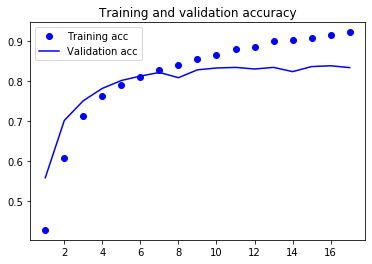

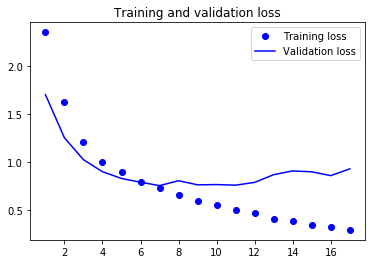

In [ ]:
plot_history(history)

In [ ]:
model = keras.models.load_model('GRUs-300.h5')
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 500, 300)          3000000   
_________________________________________________________________
bidirectional_1 (Bidirection (None, 500, 128)          140160    
_________________________________________________________________
gru_2 (GRU)                  (None, 64)                37056     
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 46)                2990      
Total params: 3,184,366
Trainable params: 184,366
Non-trainable params: 3,000,000
______________________________________

In [ ]:
model.layers[0].trainable = True
for i in range(1, len(model.layers)):
    model.layers[i].trainable = False

model.compile(optimizer='adam',
              loss='',
              metrics=['acc'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 500, 300)          3000000   
_________________________________________________________________
bidirectional_1 (Bidirection (None, 500, 128)          140160    
_________________________________________________________________
gru_2 (GRU)                  (None, 64)                37056     
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 46)                2990      
Total params: 3,184,366
Trainable params: 3,000,000
Non-trainable params: 184,366
______________________________________

In [ ]:
# This is an important technique one needs to learn
callbacks_list = [
    keras.callbacks.EarlyStopping(monitor='val_loss', patience=10,),
    keras.callbacks.ModelCheckpoint(filepath='GRUs-300_retrain.h5', monitor='val_acc', save_best_only=True,)]


history = model.fit(x_train, y_train, shuffle=True,
                    epochs=200,
                    batch_size=64,
                    callbacks=callbacks_list,
                    validation_data=(x_val, y_val))

/Applications/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 7000 samples, validate on 1982 samples
Epoch 1/200
7000/7000 [==============================] - 129s 18ms/step - loss: 0.6364 - acc: 0.8470 - val_loss: 0.7392 - val_acc: 0.8269
Epoch 2/200
7000/7000 [==============================] - 125s 18ms/step - loss: 0.5879 - acc: 0.8580 - val_loss: 0.7310 - val_acc: 0.8310
Epoch 3/200
7000/7000 [==============================] - 125s 18ms/step - loss: 0.5608 - acc: 0.8669 - val_loss: 0.7301 - val_acc: 0.8315
Epoch 4/200
7000/7000 [==============================] - 130s 19ms/step - loss: 0.5303 - acc: 0.8730 - val_loss: 0.7287 - val_acc: 0.8365
Epoch 5/200
7000/7000 [==============================] - 129s 18ms/step - loss: 0.4935 - acc: 0.8796 - val_loss: 0.7321 - val_acc: 0.8360
Epoch 6/200
7000/7000 [==============================] - 132s 19ms/step - loss: 0.4745 - acc: 0.8847 - val_loss: 0.7332 - val_acc: 0.8375
Epoch 7/200
7000/7000 [==============================] - 129s 18ms/step - loss: 0.4481 - acc: 0.8893 - val_loss: 0.7365 - va

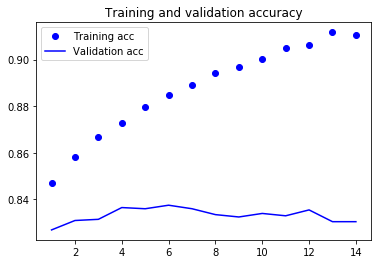

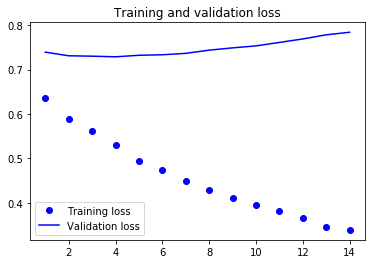

In [ ]:
plot_history(history)

In [ ]:
model = keras.models.load_model('GRUs-300_retrain.h5')

/Applications/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


In [ ]:
test_texts = []
for data in test_data:
    decoded_newswire = ' '.join([reverse_word_index.get(i - 3, '?') for i in data])
    test_texts.append(decoded_newswire)
sequences = tokenizer.texts_to_sequences(test_texts)
test_data = pad_sequences(sequences, maxlen=maxlen)
x_test = test_data
y_test = one_hot_test_labels

Evaluating the model:

In [ ]:
model.evaluate(x_test, y_test)

2246/2246 [==============================] - 11s 5ms/step


[0.749587326100758, 0.8321460485458374]

In [ ]:
words = ['earning', 'report', 'quarter', 'profit', 'top', 'estimate']
for word in words:
    print(word, word_index[word])

earning 6286
report 229
quarter 95
profit 71
top 1111
estimate 807


Test accuracy: 83%
---
